### Introduction
How do you help the police become more efficient?  There are several ways to data to help the police department, but one way is to reduce their response time.  Generally, police patrol the streets to be visible as their presence has been shown to reduce crime.  But what if we can use data to predict when, where, and what type of crime will occur so that the police have a more targeted area to patrol?  If a crime occurs as predicted, the police will be nearby to handle the situation, reducing travel time.  

Predicting when, where, and what type of crime is a very big endeavor however.  Thus, this capstone project is the first step to this vision, in which I predict the type of crime given location, date and time.  The features are summarized in the following table.

| Feature | Description   |
|------|------|
|   DR_ID  | The official file number made up of the year, area ID, and 5 digits|
|   Date and Time  | In MM/DD/YYYY and military time format |
|   Area  | There are 21 areas with unique names and corresponding codes|
|   Crime Description  | A description and corresponding code to each unique crime|
|   Location  |Street address of where the crime occurred rounded to the nearest hundred block for anonymity|
|   Cross Street  | Cross street of the location|
|   Coordinates  | The latitude and longitude of the crime location|

The data was taken from [the City of Los Angeles](https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/63jg-8b9z).  It should be noted that the full dataset runs from 2010 to the time of writing (10/2019) with 28 columns.  However, I have culled the columns down to 11 to avoid target leakage, and taken data from 2017 to present time to reduce computational load.  

This notebook is centered around 6 different questions:
1.  What are the most common types of crime?
2.  When is crime happening?
3.  Have any areas increased/decreased in crime rate?
4.  Are there hotspots for specific types of crime?

After, I will split the data into a training set (years 2017-18) and use several classification models to predict crimes happening in 2019.  

### 1 - Importing the Data
The date feature should be loaded as a datetime datatype using pandas's 'parse_dates' function.  It should be noted if this feature is not loaded as a datetime, all dates will have a time set to midnight which is the incorrect time.  There is a separate column for time.  In addition, the website from which I downloaded the data from says that if any locations are unknown, its coordinates will be entered as (0, 0).  From the describe function, we see that indeed, there latitudes and longitudes at 0, both of which are pretty far away from their means.  These will need to be taken care of in a future section.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from tabulate import tabulate
import holidays
import fancyimpute
from scipy import spatial
import shap

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,log_loss
from sklearn.linear_model import LogisticRegression


C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('Crime_Data_from_2017_on_culled.csv', parse_dates=['DATE OCC'])

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620647 entries, 0 to 620646
Data columns (total 12 columns):
DR_NO          620647 non-null int64
DATE OCC       620647 non-null datetime64[ns]
TIME OCC       620647 non-null int64
AREA           620647 non-null int64
AREA NAME      620647 non-null object
Rpt Dist No    620647 non-null int64
Crm Cd         620647 non-null int64
Crm Cd Desc    620647 non-null object
Premis Desc    620531 non-null object
LOCATION       620647 non-null object
LAT            620647 non-null float64
LON            620647 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 226.3 MB


In [4]:
df.describe()

,DR_NO,TIME OCC,AREA,Rpt Dist No,Crm Cd,LAT,LON
count,6.206470e+05,620647.000000,620647.000000,620647.000000,620647.000000,620647.000000,620647.000000
mean,1.802400e+08,1358.111108,10.934351,1139.948096,506.693459,34.076006,-118.354779
std,7.941326e+06,647.808264,6.077730,607.772446,209.839038,0.182597,0.509389
min,2.100000e+02,1.000000,1.000000,100.000000,110.000000,0.000000,-118.667700
25%,1.715131e+08,930.000000,6.000000,636.000000,330.000000,34.012100,-118.433400
50%,1.809040e+08,1430.000000,11.000000,1169.000000,442.000000,34.061000,-118.326700
75%,1.902122e+08,1900.000000,16.000000,1656.000000,626.000000,34.170000,-118.276100
max,1.999239e+08,2359.000000,21.000000,2199.000000,956.000000,34.332800,0.000000


In [5]:
df.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Premis Desc,LOCATION,LAT,LON
0,170904716,2017-01-13,1930,9,Van Nuys,909,510,VEHICLE - STOLEN,STREET,WOODMAN,34.2062,-118.4312
1,171425801,2017-12-05,1530,14,Pacific,1472,510,VEHICLE - STOLEN,BEACH,6900 PACIFIC AV,33.9577,-118.4497
2,171417781,2017-07-31,915,14,Pacific,1472,310,BURGLARY,SINGLE FAMILY DWELLING,6600 VISTA DEL MAR,33.9612,-118.4498
3,170516522,2017-09-25,1800,5,Harbor,584,510,VEHICLE - STOLEN,DRIVEWAY,700 W 26TH ST,33.7206,-118.2938
4,170810515,2017-05-22,2130,8,West LA,836,510,VEHICLE - STOLEN,STREET,1800 PARNELL AV,34.0530,-118.4302


### 2 - What are the Most Common Types of Crimes?
Since I'm trying to predict the type of crime, lets see what we can find out about it.  The first thing I noticed is that there are 140 different types of crimes, ranging from theft, burglary, assault, arson, crimes of sexual nature, and more.  However, the 16 most common crimes accounts for 80% of all crimes.  As such, I will rename anything not in the top 16 most common crimes as 'other'.

In [6]:
df['Crm Cd Desc'].value_counts()[:16].sum()/df.shape[0]*100

79.99313619497073

In [7]:
crm_desc_other_lst = list(df['Crm Cd Desc'].value_counts()[16:].index)

In [8]:
df['Crm Cd Desc'] = df['Crm Cd Desc'].apply(lambda x: x if x not in crm_desc_other_lst else 'OTHER')

Looking at the remaining crimes, they can be consolidated even more.  For example, there are two types of vandalism listed depending on if its a felony or misdemeanor.  While felonies and misdemeanors are important when doling out punishments in court, the crime is the same so they can be combined.  **In the end, the 3 most common type of crimes aside from 'other' (20%) are assault (19%), theft from vehicles (14%), and theft (13%).**

In [9]:
crime_dict = {'THEFT PLAIN - PETTY ($950 & UNDER)': 'THEFT', 
              'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD': 'THEFT',
             'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)': 'THEFT FROM VEHICLE', 
             'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)': 'THEFT FROM VEHICLE', 
             'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'VANDALISM', 
             'VANDALISM - MISDEAMEANOR ($399 OR UNDER)': 'VANDALISM', 
             'INTIMATE PARTNER - SIMPLE ASSAULT': 'ASSAULT', 
              'BATTERY - SIMPLE ASSAULT': 'ASSAULT', 
             'INTIMATE PARTNER - AGGRAVATED ASSAULT': 'ASSAULT', 
              'SHOPLIFTING - PETTY THEFT ($950 & UNDER)': 'THEFT', 
             'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': 'ASSAULT', 
              'BURGLARY FROM VEHICLE': 'THEFT FROM VEHICLE',
             'CRIMINAL THREATS - NO WEAPON DISPLAYED': 'CRIMINAL THREATS - NO WEAPON'}

In [10]:
df['Crm Cd Desc'] = df['Crm Cd Desc'].apply(lambda x: crime_dict[x] if x in crime_dict.keys() else x)

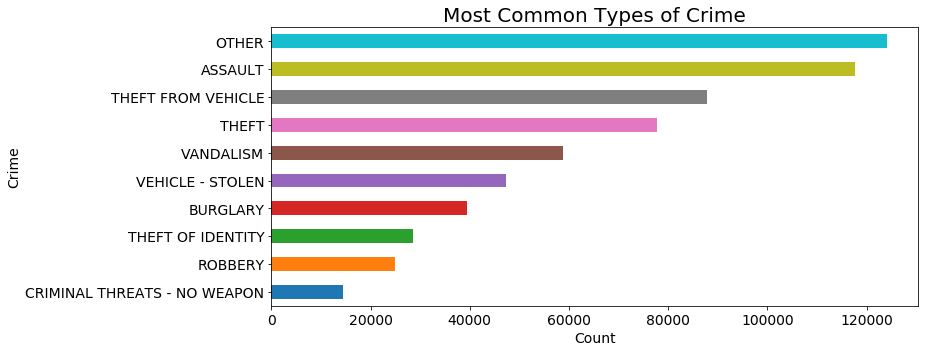

In [12]:
fig, ax = plt.subplots(figsize=(13, 5))
df.groupby('Crm Cd Desc').count()['LAT'].sort_values(ascending = True).plot(kind='barh')
plt.title('Most Common Types of Crime', fontsize = 20)
plt.ylabel('Crime', fontsize = 14)
plt.xlabel('Count', fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

### 3 - When is Crime Happening? 
When thinking about time, there are two parts: time of the year, and time of day.  Perhaps there is a cyclical pattern?

To find out, first I must extract the year, month, day, and day of week that the crime occurred, which is where parsing the date feature as a datetime comes in handy.  

In [13]:
df['Year'] = df['DATE OCC'].apply(lambda x: x.year)
df['Month'] = df['DATE OCC'].apply(lambda x: x.month)
df['Day'] = df['DATE OCC'].apply(lambda x: x.day)
df['dayofweek'] = df['DATE OCC'].apply(lambda x: x.dayofweek)

#### 3.1 - What Time of Year has the Most Crime?
Below is a plot showing the number of crimes that occurred in 2017 and 2018. There are two things I notice: 1)  there are a lot of spikes occurring at pretty even intervals, and 2) the number of crimes per day hovers at around 620 (indicated by the horizontal orange line), meaning the overall number of crimes has not decreased in this time frame.


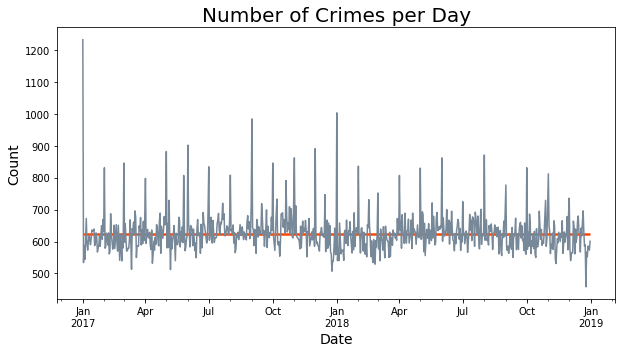

In [16]:
df[df['Year']!=2019].groupby('DATE OCC').count()['TIME OCC'].plot(figsize=(10, 5), color = 'lightslategrey')
plt.hlines(df[df['Year']!=2019].groupby('DATE OCC').count()['TIME OCC'].median(), 
           xmin = '2017-01-01 00:00:00', xmax = '2018-12-31 00:00:00', color = 'orangered',
          linewidth = 2.5)
plt.title('Number of Crimes per Day', fontsize = 20)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=14)

I wanted to dig deeper into what those spikes were.  Since there are around 24 spikes, this is probably a monthly occurrence.  **Indeed, there is a spike on the first of every month.  **

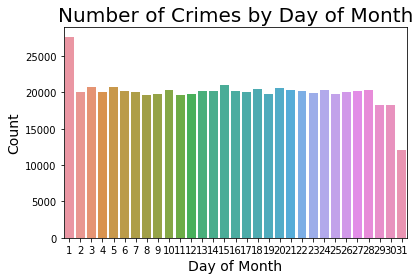

In [15]:
sns.countplot(x = 'Day', data = df)
plt.title('Number of Crimes by Day of Month', fontsize = 20)
plt.xlabel('Day of Month', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

What could be causing these spikes?  Do all crimes increase on the first, or only certain ones?  Below are two plots depicting the number of crimes on a typical day (left) and the number of crimes on the first of the month (right).  For easy viewing, on the plot with crimes on the first of the month, I've put horizontal bars on each crime to indicate the median number for that particular crime.  It should be apparent that the crimes that drastically increased are 'other' and theft of identity, with 50% and ~115% respectively.  Crimes with moderate increases are assault (15% increase), theft (25% increase), and burglary (28% increase).  

In [17]:
crime_order = ['OTHER', 'ASSAULT', 'THEFT FROM VEHICLE', 'THEFT', 'VANDALISM', 'VEHICLE - STOLEN', 'BURGLARY', 
'THEFT OF IDENTITY', 'ROBBERY', 'CRIMINAL THREATS - NO WEAPON']

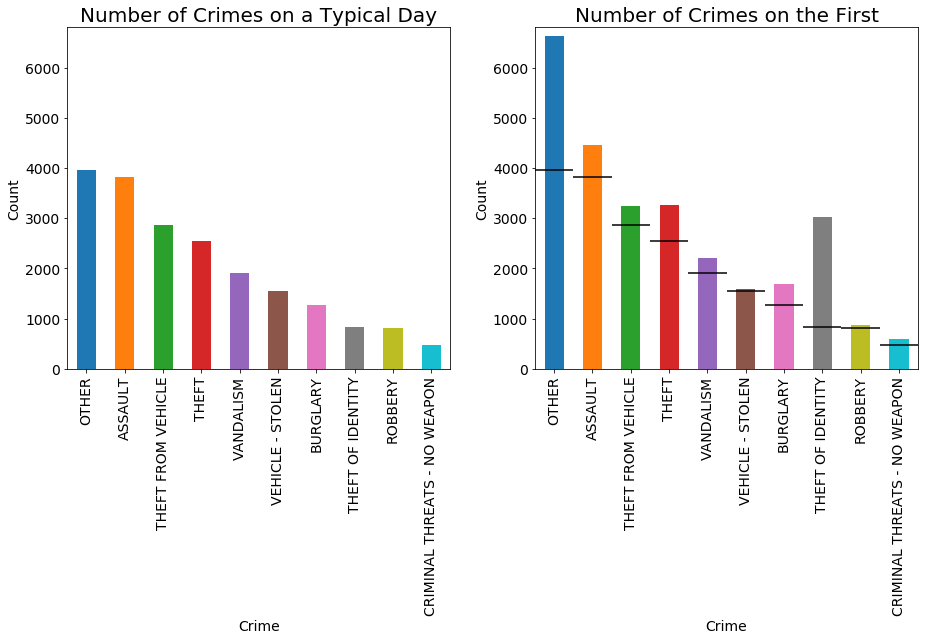

In [18]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(13, 9))
df.groupby(['Day', 'Crm Cd Desc']).count()['LAT'].unstack().median().sort_values(ascending = False).plot(kind = 'bar', ax = axis1)
df[df['Day']==1].groupby('Crm Cd Desc').count()['LAT'].loc[crime_order].plot(kind='bar', ax = axis2)

axis1.set_title('Number of Crimes on a Typical Day', fontsize = 20)
axis2.set_title('Number of Crimes on the First', fontsize = 20)

for ax in [axis1, axis2]:
    ax.set_ylim([0, 6800])
    ax.set_ylabel('Count', fontsize = 14)
    ax.set_xlabel('Crime', fontsize = 14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.tight_layout()

for i in range(0,10):
    axis2.hlines(y = df.groupby(['Day', 'Crm Cd Desc']).count()['LAT'].unstack().median().sort_values(ascending = False)[i], xmin = i-0.5, xmax = i+0.5)


I also wanted to check if there are any yearly (below left) or weekly (below right) cyclical patterns.  For number of crimes per month, there doesn't seem to be much variation.  As for days of week, I am honestly surprised there aren't more crimes on the weekend.  In fact, it seems like Mondays and Fridays have a slight uptick in crime rates.   

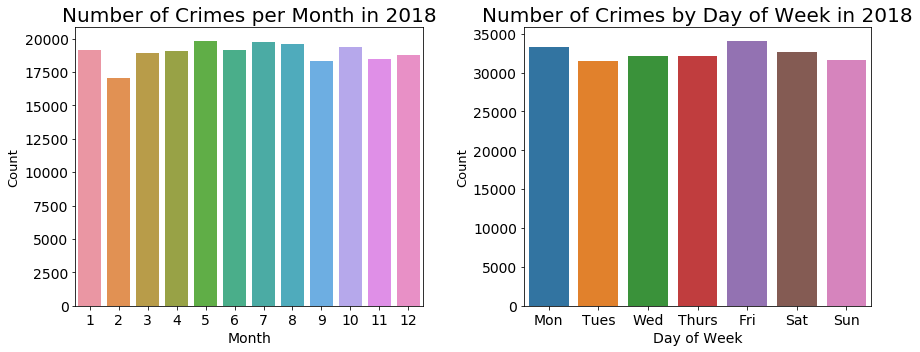

In [19]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(13, 5))

sns.countplot(x = 'Month', data = df[df['Year']==2018], ax = axis1)
sns.countplot(x = 'dayofweek', data = df[df['Year']==2018], ax = axis2)

axis1.set_title('Number of Crimes per Month in 2018', fontsize = 20)
axis2.set_title('Number of Crimes by Day of Week in 2018', fontsize = 20)

axis1.set_xlabel('Month', fontsize = 14)
axis2.set_xlabel('Day of Week', fontsize = 14)

for ax in [axis1, axis2]:
    ax.set_ylabel('Count', fontsize = 13)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
axis2.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()

#### 3.2 - What time of Day is Most Crime Ridden?
The second part to this section involves exploring fluctuations in crimes and the time of day. Below is the distribution of number of crimes throughout the day.  Starting at the lowest point, at 5 am, as people start waking up the number of crimes increases quite drastically until 8 am.  After 8 am, crime still increases until it peaks at 6 pm and then decreases until 5 am.  The one anomaly to this distribution is the** huge spike at noon, which is when the most crime happened**.  

In [20]:
def get_hour(col):
    return np.floor(col/100)

In [21]:
df['Hour'] = df['TIME OCC'].apply(get_hour)

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


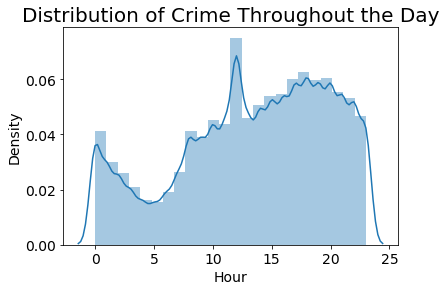

In [22]:
sns.distplot(df['Hour'], bins = 24)
plt.title('Distribution of Crime Throughout the Day', fontsize = 20)
plt.xlabel('Hour', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)

I wanted to see what was going on at noon. Below are the average number of crimes throughout the day (left) and at noon (right).  In the plot for noon crimes, I've plotted horizontal lines on each type of crime to indicate the average number of crimes throuhgout the day for easy comparison.  **At noon, there are huge uptakes in crimes related to theft of identity (150% increase), thefts (70% increase), and 'other' (70% increase).**  There are also moderate increases in assaults (~20%) and burglaries (43% increase).  

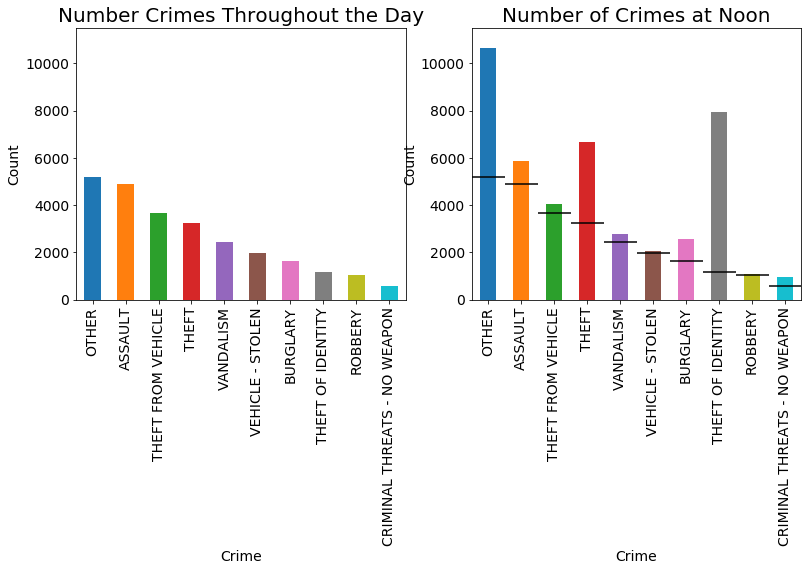

In [23]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(13, 5))

(df.groupby('Crm Cd Desc').count()['LAT'].sort_values(ascending = False)/24).plot(kind = 'bar', ax = axis1)
(df[df['Hour']==12].groupby('Crm Cd Desc').count()['LAT'].loc[crime_order]).plot(kind='bar', ax = axis2)

axis1.set_title('Number Crimes Throughout the Day', fontsize = 20)
axis2.set_title('Number of Crimes at Noon', fontsize= 20)

for ax in [axis1, axis2]:
    ax.set_ylabel('Count', fontsize = 14)
    ax.set_xlabel('Crime', fontsize = 14)
    ax.set_ylim([0,11500])
    ax.tick_params(axis='both', which='major', labelsize=14)

for i in range(0,10):
    axis2.hlines(y = (df.groupby('Crm Cd Desc').count()['LAT'].sort_values(ascending = False)/24)[i], xmin = i-0.5, xmax = i+0.5)


#### 3.3 - How do Crimes Fluctuate Throughout Day?
Seeing this spike at noon made me wonder if the frequency of each type of crimes fluctuates throughout the day.  **I've grouped the ten types if crimes into 3 categories.**  The first has a spike at noon (and often at 8 am as well), with a decrease in crime after the 3 pm.  Crimes in this first category are 'other' and thefts not involving vehicles.  The second category also involves a spike at noon (and smaller spikes at 8 am), but this type of crime tends to increase after the spike.  These crimes involve assault, thefts involving vehicles, and vandalism.  The third category are crimes that are both low in number and don't have spikes.  These crimes are robberies and criminal threats.  

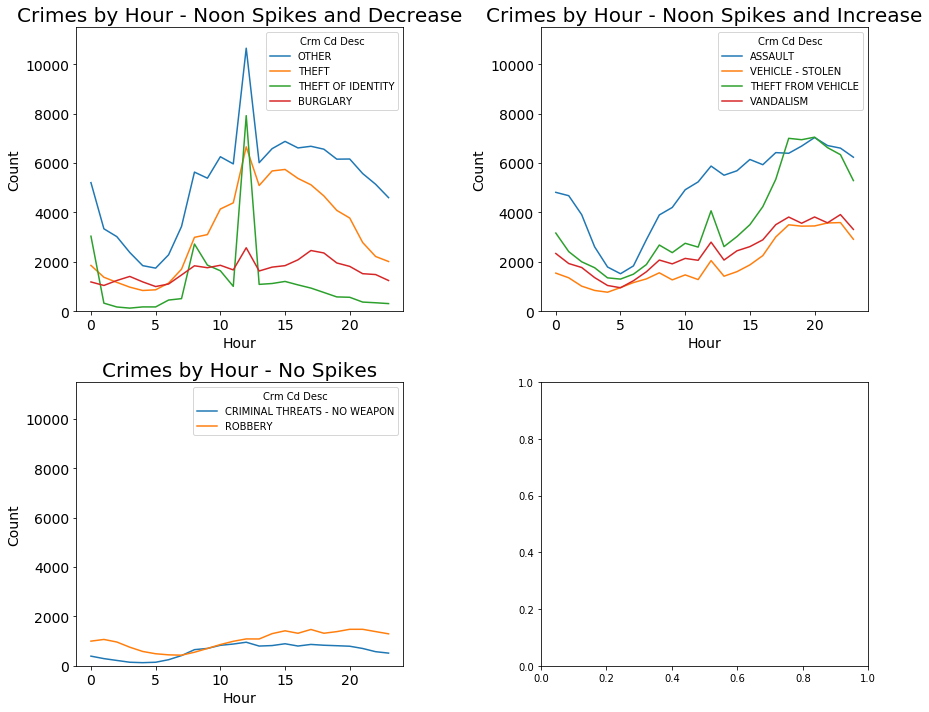

In [24]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2, 2, figsize=(13, 10))

df.groupby(['Hour', 'Crm Cd Desc']).count()['AREA '].unstack()[['OTHER', 'THEFT', 
                                                                'THEFT OF IDENTITY', 
                                                                'BURGLARY']].plot(ax = axis1)
df.groupby(['Hour', 'Crm Cd Desc']).count()['AREA '].unstack()[['ASSAULT', 'VEHICLE - STOLEN', 
                                                                'THEFT FROM VEHICLE', 
                                                                'VANDALISM']].plot(ax = axis2)
df.groupby(['Hour', 'Crm Cd Desc']).count()['AREA '].unstack()[['CRIMINAL THREATS - NO WEAPON', 
                                                                'ROBBERY']].plot(ax = axis3)
axis1.set_title('Crimes by Hour - Noon Spikes and Decrease', fontsize = 20)
axis2.set_title('Crimes by Hour - Noon Spikes and Increase', fontsize = 20)
axis3.set_title('Crimes by Hour - No Spikes', fontsize = 20)

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Count', fontsize = 14)
    ax.set_xlabel('Hour', fontsize = 14)
    ax.set_ylim([0,11500])
    ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.tight_layout()

### 4 - Have any Areas Increased or Decreased Total Crime Rates?
In LA county, there are 21 unique areas/districts that the police patrol.  The area with the most crime is 77th Street whereas the area with lowest crime rate is foothill.  Recall that overall, crime rates seem to be pretty steady between 2017-18. However, that doesn't mean that there aren't fluctuations in crime rate in each area throughout the years.  

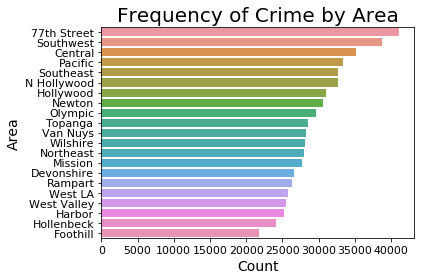

In [26]:
sns.countplot(y = 'AREA NAME', order = df['AREA NAME'].value_counts().index, data = df)
plt.title('Frequency of Crime by Area', fontsize = 20)
plt.ylabel('Area', fontsize = 14)
plt.xlabel('Count', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.tight_layout()

In [27]:
area_groupby = df[df['Year']!=2019].groupby(['Year', 'AREA NAME']).count()['AREA '].unstack()

In [28]:
def percent_change(val1, val2):
    num = val2 - val1
    den = np.absolute(val1)
    return num/den*100

In [29]:
neg_trending_areas = [col for col in area_groupby.columns if percent_change(area_groupby[col][2017], area_groupby[col][2018]) < -5]
pos_trending_areas = [col for col in area_groupby.columns if percent_change(area_groupby[col][2017], area_groupby[col][2018]) > 5]

Below I've plotted areas that have had at least a 5% change between 2017-18.  **Areas that have increased (below left) are Central, West LA, and Wilshire.  Areas that have decreased (below right) are Devonshire, Harbor, Mission, and Newton.**

From the slopes, we can visually see if an area had a larger change compared to the others. In the case of areas with increased crime rates, Central has a larger slope than the other two, suggesting that extra resources should be pooled to handling that increase in crime for 2019.  On the other hand, Devonshire has the largest decrease in crime in this time period.  Can the department pull some resources from Devonshire and pool it into Central?   

It should be noted that there is a feature with reported district numbers ('Rpt Dist No').  This feature indicate subsections of the main 21 areas, so I will not be doing a deep dive on district numbers for this data exploration.  

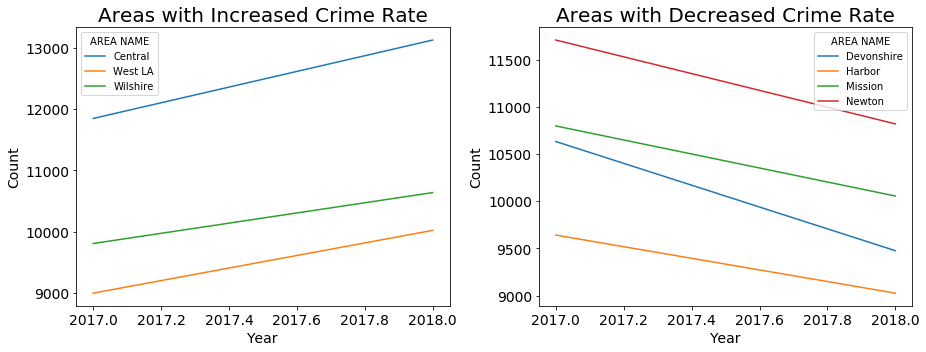

In [30]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(13, 5))

area_groupby[pos_trending_areas].plot(ax = axis1)
area_groupby[neg_trending_areas].plot(ax = axis2)

axis1.set_title('Areas with Increased Crime Rate', fontsize = 20)
axis2.set_title('Areas with Decreased Crime Rate', fontsize = 20)

for ax in [axis1, axis2]:
    ax.set_xlabel('Year', fontsize = 14)
    ax.set_ylabel('Count', fontsize = 14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.tight_layout()

### 5 - Are there Hotspots for Specific Types of Crime?
I suspect that there are certain areas that have certain types of crimes.  For example shoplifting would most likely be done at a shopping mall and perhaps around holidays or burglaries would probably happen more in residential areas instead of industrial areas.  

Before I dive into that though, I need to do a little data cleaning.  Recall that if the coordinates were unknown, then the latitude and longitude were inputted as (0,0).  There are 11 rows without coordinates.  The data is rich enough that I will just drop these.  

In [31]:
no_location_index = df[(df['LON']==0)].index

In [32]:
df.drop(no_location_index, inplace = True)

In [33]:
coords_df = pd.DataFrame()
coords_df['LAT'] = df['LAT']
coords_df['LON'] = df['LON']

In [34]:
coords_df['Coords'] = coords_df['LAT'].apply(lambda x: str(x)) + coords_df['LON'].apply(lambda x: str(x))

In [35]:
coords_df = coords_df.drop_duplicates('Coords')

Below I've plotted all the unique coordinates in the dataset.  Since crime is so widespread, its pretty easy to pinpoint certain landmarks of LA.  For example, the white space centered at (-118.55, 34.1) is Topanga State Park, a place where you don't expect to see much crime. The white space at (-118.3, 34.2) is another state park that opens up to the mountains of Angeles National Forest to the east.  The white spaces at (-118.25, 33.85) and (-118.35, 33.85) are a little perplexing, as those represent Torrance and Carson, two cities in LA county.  It is possible they are handled by different law enforcement.

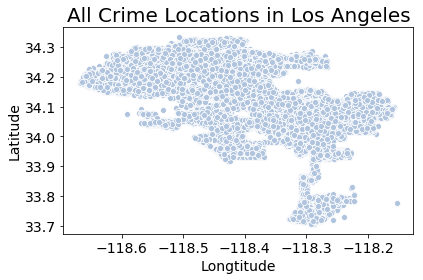

In [36]:
sns.scatterplot(x = 'LON', y='LAT', data = coords_df, color = 'lightsteelblue')
plt.title('All Crime Locations in Los Angeles', fontsize = 20)
plt.xlabel('Longtitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()


Below I've plotted hotspots for 4 different types of crimes.  The first, assaults (top left), is mainly located in downtown LA and extends west towards the Staples Center, with a smaller hotspot in South LA.  The second, thefts from vehicles (top right), has three hotspots.  From left to right, they are located in Hollywood, east Hollywood, and near the Dodgers Stadium.  The third crime, thefts, is mainly located in downtown LA.  Lastly, I wanted to look at identity theft (bottom right) since it seemed to have so many irregularities.  There are once again 3 hotspots, but more spread out throughout the county.  From left to right, they are located at Westfield Topanga mall (apparnatly a pretty well known mall), north Hollywood, and downtown LA.  

It seems like much of the crimes will be centered around downtown, so it is likely that police can station themselves downtown and find all sorts of crimes going on.  Pinpointing the secondary and tertiary hotspots would probably be more helpful.

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


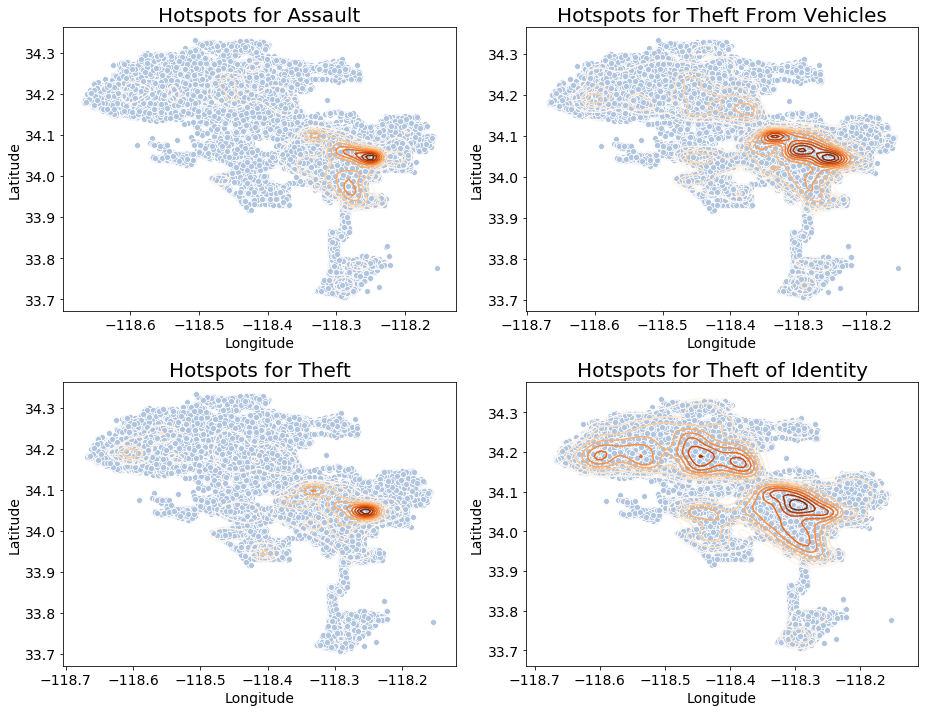

In [37]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2, 2, figsize=(13, 10))

sns.scatterplot(x = 'LON', y='LAT', data = coords_df, color = 'lightsteelblue', ax = axis1)
sns.kdeplot(df[df['Crm Cd Desc']=='ASSAULT']['LON'], df[df['Crm Cd Desc']=='ASSAULT']['LAT'], 
            shaded = True, cmap = 'Oranges', ax = axis1)

sns.scatterplot(x = 'LON', y='LAT', data = coords_df, color = 'lightsteelblue', ax = axis2)
sns.kdeplot(df[df['Crm Cd Desc']=='THEFT FROM VEHICLE']['LON'], 
            df[df['Crm Cd Desc']=='THEFT FROM VEHICLE']['LAT'], 
            shaded = True, cmap = 'Oranges', ax = axis2)

sns.scatterplot(x = 'LON', y='LAT', data = coords_df, color = 'lightsteelblue', ax = axis3)
sns.kdeplot(df[df['Crm Cd Desc']=='THEFT']['LON'], df[df['Crm Cd Desc']=='THEFT']['LAT'], 
            shaded = True, cmap = 'Oranges', ax = axis3)

sns.scatterplot(x = 'LON', y='LAT', data = coords_df, color = 'lightsteelblue', ax = axis4)
sns.kdeplot(df[df['Crm Cd Desc']=='THEFT OF IDENTITY']['LON'], 
            df[df['Crm Cd Desc']=='THEFT OF IDENTITY']['LAT'], 
            shaded = True, cmap = 'Oranges', ax = axis4)

axis1.set_title('Hotspots for Assault', fontsize = 20)
axis2.set_title('Hotspots for Theft From Vehicles', fontsize = 20)
axis3.set_title('Hotspots for Theft', fontsize = 20)
axis4.set_title('Hotspots for Theft of Identity', fontsize = 20)

for ax in [axis1, axis2, axis3, axis4]:
    ax.set_xlabel('Longitude', fontsize = 14)
    ax.set_ylabel('Latitude', fontsize =14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
plt.tight_layout()

### 6  - What Types of Areas are Crimes Most Prevalent?
By types of areas, I refer to if the location is a restaurant, a street, bus stop, store, etc.  The dataset provides this already, with 308 unique types of areas.  First though, there are 116 missing values I need to deal with.  

Since the 2019 data is my test set, I don't want to impute any of those values so I will drop those rows.  As for the rest, I will find if these missing premises share a coordinate with other crimes.  If so, then find the mode of the premise and return it.  This method ends up removing all missing premises.  

In [122]:
df.drop(df[(df['Premis Desc'].isnull()) & (df['Year']==2019)].index, axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)

In [180]:
def get_premise(lat, lon):
    tmp = df[(df['LAT']==lat) & (df['LON']==lon)][['Premis Desc', 'LAT', 'LON']]
    if tmp.shape[0] != 0:
        return tmp['Premis Desc'].mode().values[0]
    else:
        return np.nan

In [185]:
condition = df['Premis Desc'].isnull()
# df.loc[condition, ['Premis Desc']] = df.loc[condition].apply(lambda x: )
df.loc[condition, ['Premis Desc']] =df.loc[condition].apply(lambda x: get_premise(x['LAT'], x['LON']), axis = 1)

Now, 308 unique values is quite a bit.  Can I consolidate these?  Turns out I can.  A lot of these values are each separate MTA lines, types of bus stops, or schools.  After conslidating, I get 180 unique values

In [188]:
def consolidate_premise(col):
    if 'MTA -' in col:
        return 'MTA LINE'
    if 'TERMINAL' in col:
        return 'NON MTA TERMINAL'
    if 'STORE' in col:
        return 'STORE'
    if 'SCHOOL' in col:
        return 'SCHOOL'
    if 'RESTROOM' in col:
        return 'RESTROOM'
    if 'BUS' in col:
        if 'BUSINESS' not in col:
            return 'BUS'
        else: return col
    if 'REDLINE' in col:
        return 'REDLINE'
    if 'BANK' in col:
        return 'BANK'
    if 'BAR/' in col:
        return 'BAR'
    if 'BEACH' in col:
        return 'BEACH'
    if 'PARKING' in col:
        return 'PARKING'
    else:
        return col

In [189]:
df['Premis Desc'] = df['Premis Desc'].apply(consolidate_premise)

In [225]:
df.reset_index(drop = True, inplace = True)

### 7 - Baseline Model
Now that I've done some data cleaning, I'd like to apply some models and get some baseline scores.  This way, I'll know if any additional feature engineering is useful or not.  The models I am choosing are logistic regression, knn, random forest, and gradient boosting classification.  

In addition, I'd like to compare two types of scoring: accuracy and log loss.  Accuracy is important to know because I can see if the models are predicting certain types of crimes particularly well or poorly.  The log loss scoring takes into account probability, as it heavily penalizes predictions that are both wrong and confident.  As a reminder, it is more desireable to have higher accuracies and lower log loss scores.

#### 7.1 - Prepping the data 
To not mess with the raw data, I made a copy of the data and named it baseline_df.  Most of the features are already in a numeric format, but the premise is not.  To change it to numeric values, I can either use dummy variables or encode them.  180 unique values would increase the dimensions of the dataset too much, so I went with endcoding them.  The crimes, or the target variable, will stay as a categorical data type.  Lastly, I split my data into a training set (years 2017-18) and a test set (year 2019).  

In [228]:
baseline_df = df.drop(['DR_NO', 'AREA NAME', 'Crm Cd', 'LOCATION', 'DATE OCC', 'TIME OCC'], axis = 1)

In [229]:
baseline_df['Premis Desc'] = baseline_df['Premis Desc'].astype('category')
baseline_df['Premis Desc'] = baseline_df['Premis Desc'].cat.codes

In [258]:
train = baseline_df[baseline_df['Year'] != 2019]
train.reset_index(drop = True, inplace = True)
test = baseline_df[baseline_df['Year'] == 2019]
test.reset_index(drop = True, inplace = True)

X_train = train.drop('Crm Cd Desc', axis = 1)
X_test = test.drop('Crm Cd Desc', axis = 1)

y_train = train['Crm Cd Desc']
y_test = test['Crm Cd Desc']

#### 7.2 - Baseline Scores
In the table below, the total accuracy and log loss outputs for logistic regression, knn, random forest, gradient boost classifiers are summarized. It should be noted that these baseline models are not optimized; I only use the default hyperparameters when possible.  The results of the accuracies and log loss scores are summarized below: 

| Model | Training Accuracy   |Test Accuracy   |Training Log Loss   |Test Log Loss   |
|------|------|
|   Baseline Logistic Regression  | 24.0%|  24.5% | 2.10 | 2.08 |
|   Baseline KNN  | 51.8%|  29.7% | 1.01 | 12.96 |
|   Baseline Random Forest  | 98%|  33.6% | 0.332 | 7.70 |
|   Baseline Gradient Boost  | 39.4%|  38.8% | 1.63 | 1.65 |


Overall, training accuracies range from ~25% to 9% and test accuracies range between ~25 to 40%.  The model with the most overfitting comes from random forest, but knn has moderate overfitting as well, whlie logistic regression and gradient boost have minimal overfitting.  These overfitting trends are similar in the log loss scoring.  **So far though, the best test accuracy and test log loss score goes to gradient boost.**

In [6]:
def get_scores(model, model_name):
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_probs = model.predict_proba(X_train)
    test_probs = model.predict_proba(X_test)
    
    print('{} has training accuracy of: {}'.format(model_name, accuracy_score(y_train, train_preds)))
    print('{} has test accuracy of: {}\n'.format(model_name, accuracy_score(y_test, test_preds)))
    
    print('{} has training log loss of: {}'.format(model_name, log_loss(y_train, train_probs)))
    print('{} has test log loss of: {}\n'.format(model_name, log_loss(y_test, test_probs)))
    
    return train_preds, test_preds, train_probs, test_probs

In [240]:
lr_baseline = LogisticRegression(solver = 'sag', multi_class='multinomial', random_state=42, n_jobs=-1)

baseline_lr_train_preds, baseline_lr_test_preds, baseline_lr_train_probs, baseline_lr_test_probs = get_scores(lr_baseline, 'Baseline logistic regression')

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Baseline logistic regression has training accuracy of: 0.2399166100317083
Baseline logistic regression has test accuracy of: 0.24501384276339616

Baseline logistic regression has training log loss of: 2.097903576966744
Baseline logistic regression has test log loss of: 2.07528587362655



In [243]:
knn_baseline = KNeighborsClassifier(n_jobs=-1)

baseline_knn_train_preds, baseline_knn_test_preds, baseline_knn_train_probs, baseline_knn_test_probs = get_scores(knn_baseline, 'Baseline knn')

Baseline knn has training accuracy of: 0.5177892043207192
Baseline knn has test accuracy of: 0.29733396357296765

Baseline knn has training log loss of: 1.0129782833040955
Baseline knn has test log loss of: 12.96064358392524



In [232]:
rf_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)

baseline_rf_train_preds, baseline_rf_test_preds, baseline_rf_train_probs, baseline_rf_test_probs = get_scores(rf_baseline, 'Baseline random forest')

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Baseline random forest has training accuracy of: 0.9798233863407406
Baseline random forest has test accuracy of: 0.33562716005426607

Baseline random forest has training log loss of: 0.3323153602394834
Baseline random forest has test log loss of: 7.6995072578675225



In [242]:
gb_baseline = GradientBoostingClassifier(random_state=42)

baseline_gb_train_preds, baseline_gb_test_preds, baseline_gb_train_probs, baseline_gb_test_probs = get_scores(gb_baseline, 'Baseline gradient boost')

Baseline gradient boost has training accuracy of: 0.3938908544193842
Baseline gradient boost has test accuracy of: 0.388192828773304

Baseline gradient boost has training log loss of: 1.6319952415280221
Baseline gradient boost has test log loss of: 1.6464236391566685



#### 7.3 - Accuracies by Crime
It is also useful to see if any of the models predict a certain type of crime particularly well or terribly and compare to the optimized models.  As these are non optimized baseline models, I'm not expecting them to be very good.  

In [148]:
def get_accuracies(predictions, y_true):
    accuracy_lst = []
    for crime in df['Crm Cd Desc'].unique(): 
        count = 0
        for i in y_true[y_true==crime].index:
            if predictions[i] == crime:
                count += 1
        accuracy_lst.append(count/y_true[y_true==crime].shape[0]*100)
    return accuracy_lst

In [267]:
lr_train_accuracies = get_accuracies(baseline_lr_train_preds, y_train)
lr_test_accuracies = get_accuracies(baseline_lr_test_preds, y_test)

knn_train_accuracies = get_accuracies(baseline_knn_train_preds, y_train)
knn_test_accuracies = get_accuracies(baseline_knn_test_preds, y_test) 

rf_train_accuracies = get_accuracies(baseline_rf_train_preds, y_train)
rf_test_accuracies = get_accuracies(baseline_rf_test_preds, y_test)

gb_train_accuracies = get_accuracies(baseline_gb_train_preds, y_train)
gb_test_accuracies = get_accuracies(baseline_gb_test_preds, y_test)

In [278]:
# tmp = {'lr': lr_train_accuracies, 'knn': knn_train_accuracies,
#        'rf': rf_train_accuracies, 'gb': gb_train_accuracies}
# baseline_train_accuracy_df = pd.DataFrame(tmp, 
#                                           index = sorted(df['Crm Cd Desc'].unique()),
#                                          columns = ['lr', 'knn', 'rf', 'gb'])

In [281]:
tmp = {'lr': lr_test_accuracies, 'knn': knn_test_accuracies,
       'rf': rf_test_accuracies, 'gb': gb_test_accuracies}
baseline_test_accuracy_df = pd.DataFrame(tmp, 
                                          index = sorted(df['Crm Cd Desc'].unique()),
                                         columns = ['lr', 'knn', 'rf', 'gb'])

Below is a heatmap to quickly see test accuracies for each model and crime type.  First, lets see what had a good accuracy.  For this, we want to look at the red/pink squares.  The highest accuracy came from gradient boosting with an accuracy of 78% for robberies.  Linear regression was also able to predict 'other' crimes fairly well, with an accuracy of 66%.  Otherwise, moderately good predictions come from random forest and knn for predicting robberies, at 53% and 45% respectively.  

As for which model had the hardest time predicting individual crimes, that seems to go to linear regression.  Linear regression has an accuracy of 0% for 4 types of crime.  The other models get close to 0% on some crimes, but none of them had 0%.  

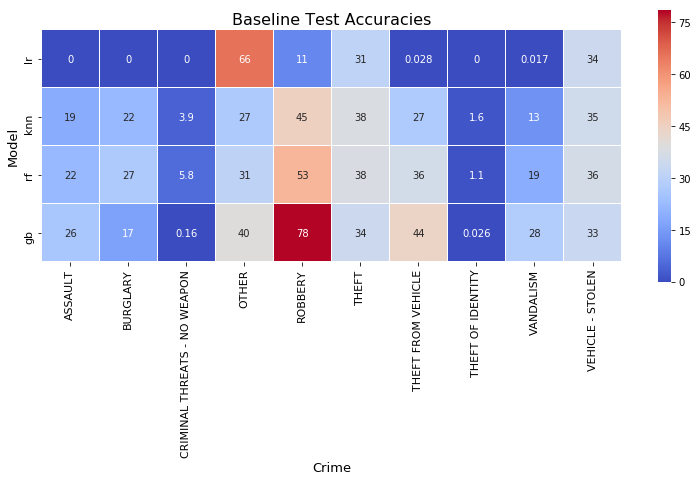

In [292]:
fig, ax = plt.subplots(figsize=(13, 5))

sns.heatmap(baseline_test_accuracy_df.T, cmap = 'coolwarm', square = True, linewidths=0.1, annot=True)
plt.title('Baseline Test Accuracies', fontsize = 16)
plt.xlabel('Crime', fontsize = 13)
plt.ylabel('Model', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=11)


### 8 - How to Improve Scores?
Generally, the way to improve accuracies and scores is more feature engineering and/or to introduce external data.  In this case, I will be doing both.

#### 8.1 - Feature Engineering
I've already done a bit of feature engineering above extracting month, year, day and day of week.  There is one more feature I believe would be useful to extract, which is holidays.  I used the [holidays package](https://pypi.org/project/holidays/) for this.  The holidays package has 10 holidays for the United States, which are the federal holidays.  It also accounts for when the hoiday is observed if it falls on a weekend. 

In [294]:
holiday_dates = holidays.UnitedStates()

In [295]:
df['holiday'] = df['DATE OCC'].apply(lambda x: True if x.date() in holiday_dates else False)

#### 8.2 - External Sources
There are two external sources I added that I thought would help improve the models: sport teams and weather.


##### 8.2.1 - Sports Teams
There are 6 major teams in Los Angeles: 

*LA basketball teams*: Lakers and Clippers  
*LA football teams*: Rams and Chargers  
*LA baseball teams*: Angels and Dodgers  

For each row, I looked at if any of the teams were playing.  If they were, I'd add if the game was at home or away and if the team won or lost.  

Click the following for links of where I gathered the data for 2018: [basketball](https://www.basketball-reference.com/teams/LAC/2018_games.html), [football](https://www.pro-football-reference.com/teams/sdg/2018-schedule.htm), and [baseball](https://www.baseball-reference.com/teams/LAD/2018-schedule-scores.shtml).  

In [299]:
lakers_dict = {}
clippers_dict = {}

In [300]:
def add_to_dict(key, value, dictionary):
    dictionary[key] = value

In [301]:
def add_basketball_info(dictionary, filename):
    tmp = pd.read_csv(filename)
    tmp['Unnamed: 5'].fillna('Home', inplace = True)
    tmp['Unnamed: 5'].replace('@', 'Away', inplace = True)
    tmp.apply(lambda x: add_to_dict(x['Date'][4:], (x['Unnamed: 5'], x['Unnamed: 7']), dictionary), axis = 1);

In [302]:
lakers_filenames = ['lakers_1516.txt', 'lakers_1617.txt', 'lakers_1718.txt', 'lakers_1819.txt']
clippers_filenames = ['clippers_1516.txt', 'clippers_1617.txt', 'clippers_1718.txt', 'clippers_1819.txt']

In [303]:
for file in lakers_filenames:
    add_basketball_info(lakers_dict, file)
for file in clippers_filenames:
    add_basketball_info(clippers_dict, file)

In [304]:
df['Lakers_game'] = df['DATE OCC'].apply(lambda x: lakers_dict[x.strftime('%b %d %Y')][0] if x.strftime('%b %d %Y') in lakers_dict.keys() else 'None')
df['Lakers_outcome'] = df['DATE OCC'].apply(lambda x: lakers_dict[x.strftime('%b %d %Y')][1] if x.strftime('%b %d %Y') in lakers_dict.keys() else 'None')

In [305]:
df['Clippers_game'] = df['DATE OCC'].apply(lambda x: clippers_dict[x.strftime('%b %d %Y')][0] if x.strftime('%b %d %Y') in clippers_dict.keys() else 'None')
df['Clippers_outcome'] = df['DATE OCC'].apply(lambda x: clippers_dict[x.strftime('%b %d %Y')][1] if x.strftime('%b %d %Y') in clippers_dict.keys() else 'None')

In [306]:
rams_dict = {}
chargers_dict = {}

In [307]:
rams_filenames = ['rams_2016.txt', 'rams_2017.txt', 'rams_2018.txt', 'rams_2019.txt']
chargers_filenames = ['chargers_2016.txt', 'chargers_2017.txt', 'chargers_2018.txt', 'chargers_2019.txt']

In [308]:
def add_football_info(dictionary, filename):
    tmp = pd.read_csv(filename)
    tmp['Unnamed: 6'].fillna('Home', inplace = True)
    tmp['Unnamed: 6'].replace('@', 'Away', inplace = True)
    tmp.apply(lambda x: add_to_dict(x['Date'], (x['Unnamed: 6'], x['Unnamed: 4']), dictionary), axis = 1)

In [309]:
for file in rams_filenames:
    add_football_info(rams_dict, file)
for file in chargers_filenames:
    add_football_info(chargers_dict, file)

In [310]:
df['Rams_game'] = df['DATE OCC'].apply(lambda x: rams_dict[x.strftime('%B %d %Y')][0] if x.strftime('%B %d %Y') in rams_dict.keys() else 'None')
df['Rams_outcome'] = df['DATE OCC'].apply(lambda x: rams_dict[x.strftime('%B %d %Y')][1] if x.strftime('%B %d %Y') in rams_dict.keys() else 'None')

In [311]:
df['Chargers_game'] = df['DATE OCC'].apply(lambda x: chargers_dict[x.strftime('%B %d %Y')][0] if x.strftime('%B %d %Y') in chargers_dict.keys() else 'None')
df['Chargers_outcome'] = df['DATE OCC'].apply(lambda x: chargers_dict[x.strftime('%B %d %Y')][1] if x.strftime('%B %d %Y') in chargers_dict.keys() else 'None')

In [312]:
angels_dict = {}
dodgers_dict = {}

angels_filenames = ['angels_2016.txt', 'angels_2017.txt', 'angels_2018.txt', 'angels_2019.txt']
dodgers_filenames = ['dodgers_2016.txt', 'dodgers_2017.txt', 'dodgers_2018.txt', 'dodgers_2019.txt']

In [313]:
def add_baseball_info(dictionary, filename):
    tmp = pd.read_csv(filename)
    tmp['Unnamed: 4'].fillna('Home', inplace = True)
    tmp['Unnamed: 4'].replace('@', 'Away', inplace = True)
    tmp.apply(lambda x: add_to_dict(' '.join(x['Date'].split()[1:]), (x['Unnamed: 4'], x['W/L'][0]), dictionary), axis = 1)

In [314]:
for file in angels_filenames:
    add_baseball_info(angels_dict, file)
for file in dodgers_filenames:
    add_baseball_info(dodgers_dict, file)

In [315]:
df['Angels_game'] = df['DATE OCC'].apply(lambda x: angels_dict[x.strftime('%B %d %Y')][0] if x.strftime('%B %d %Y') in angels_dict.keys() else 'None')
df['Angels_outcome'] = df['DATE OCC'].apply(lambda x: angels_dict[x.strftime('%B %d %Y')][1] if x.strftime('%B %d %Y') in angels_dict.keys() else 'None')

In [316]:
df['Dodgers_game'] = df['DATE OCC'].apply(lambda x: dodgers_dict[x.strftime('%B %d %Y')][0] if x.strftime('%B %d %Y') in dodgers_dict.keys() else 'None')
df['Dodgers_outcome'] = df['DATE OCC'].apply(lambda x: dodgers_dict[x.strftime('%B %d %Y')][1] if x.strftime('%B %d %Y') in dodgers_dict.keys() else 'None')

##### 8.2.2 - Weather
Weather data was collected from [NOAA](https://www.ncdc.noaa.gov/cdo-web/search) for the Los Angeles County area.  The variables I was interested in are summarized in the table below: 

| Variable | Description   |
|------|------|
|   awnd  | Average windspeed|
|   prcp  | Precipitation|
|   tmin and tmax  | Minimum and maximum temperatures|

In [3]:
weather_df = pd.read_csv('weather_w_coords.csv', parse_dates=['DATE'])

In [4]:
weather_df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,PRCP,TMAX,TMIN,WDF2,WDF5
0,US1CALA0036,"PASADENA 2.0 SE, CA US",34.1392,-118.1161,225.2,2016-01-01,NaN,0.00,NaN,NaN,NaN,NaN
1,US1CALA0036,"PASADENA 2.0 SE, CA US",34.1392,-118.1161,225.2,2016-01-02,NaN,0.00,NaN,NaN,NaN,NaN
2,US1CALA0036,"PASADENA 2.0 SE, CA US",34.1392,-118.1161,225.2,2016-01-03,NaN,0.00,NaN,NaN,NaN,NaN
3,US1CALA0036,"PASADENA 2.0 SE, CA US",34.1392,-118.1161,225.2,2016-01-04,NaN,0.00,NaN,NaN,NaN,NaN
4,US1CALA0036,"PASADENA 2.0 SE, CA US",34.1392,-118.1161,225.2,2016-01-05,NaN,2.64,NaN,NaN,NaN,NaN


There are 84 unique weather stations, but a lot of them have a lot of missing information.  I've isolated the stations that have at least 50% of the data available for average windspeed.  This returns 8 stations that have 99% of the data I need; these 8 stations I'll call active stations.  The rest of the 1% are missing values which I use the package fancyimpute to impute values for me.

In [5]:
active_stations = [station for station in weather_df['NAME'].unique() if weather_df[weather_df['NAME']==station]['AWND'].isnull().sum()/weather_df[weather_df['NAME']==station].shape[0]<0.5]

In [6]:
weather_imputed_df = weather_df[weather_df['NAME'].isin(active_stations)]

In [7]:
tmp = weather_imputed_df[['NAME', 'DATE']]
tmp.reset_index(drop = True, inplace = True)

In [15]:
imputer = fancyimpute.IterativeImputer(verbose=0)

weather_imputed_df = pd.DataFrame(imputer.fit_transform(weather_imputed_df.drop(['STATION','NAME', 'DATE'], axis = 1)), columns =['LATITUDE', 'LONGITUDE', 'ELEVATION','AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5'])

Just to make sure the imputation didn't do anything crazy, I'll compare the means and standard deviations for the wind, precipitation, and temperatures before and after imputation.  There seems to be nothing amiss after imputation. 

In [16]:
weather_df[weather_df['NAME'].isin(active_stations)][['AWND', 'PRCP', 'TMAX', 'TMIN']].describe()

,AWND,PRCP,TMAX,TMIN
count,11039.000000,11052.000000,11046.000000,11045.000000
mean,4.803798,0.032809,75.607098,57.389860
std,2.499994,0.179204,9.854812,7.660508
min,0.000000,0.000000,52.000000,35.000000
25%,3.130000,0.000000,68.000000,52.000000
50%,4.700000,0.000000,75.000000,58.000000
75%,6.040000,0.000000,82.000000,63.000000
max,23.040000,3.970000,117.000000,84.000000


In [17]:
weather_imputed_df[['AWND', 'PRCP', 'TMAX', 'TMIN']].describe()

,AWND,PRCP,TMAX,TMIN
count,11055.000000,11055.000000,11055.000000,11055.000000
mean,4.802924,0.032824,75.607788,57.391061
std,2.499145,0.179182,9.851652,7.657480
min,0.000000,0.000000,52.000000,35.000000
25%,3.130000,0.000000,68.000000,52.000000
50%,4.700000,0.000000,75.000000,58.000000
75%,6.040000,0.000000,82.000000,63.000000
max,23.040000,3.970000,117.000000,84.000000


Lastly, I will add the average wind speed, precipitation levels and temperature to the dataset by finding the nearest active station, matching dates, and inserting the weather data.  

In [18]:
weather_imputed_df['Coords'] = weather_imputed_df.apply(lambda x: (x['LATITUDE'], x['LONGITUDE']), axis = 1)
weather_imputed_df = pd.concat([tmp, weather_imputed_df], axis = 1)

In [19]:
weather_imputed_df['Year'] = weather_imputed_df['DATE'].apply(lambda x: x.year)
weather_imputed_df['Month'] = weather_imputed_df['DATE'].apply(lambda x: x.month)
weather_imputed_df['Day'] = weather_imputed_df['DATE'].apply(lambda x: x.day)

In [20]:
airport_coords = list(weather_imputed_df['Coords'].unique())
airport_tree = spatial.KDTree(airport_coords)

In [9]:
def get_wind(cols):
    lat, lon, year, month, day = cols[0], cols[1], cols[2], cols[3], cols[4]
    airport_name = active_stations[airport_tree.query([lat, lon])[1]]
    try:
        awnd = weather_imputed_df[(weather_imputed_df['NAME']==airport_name) & (weather_imputed_df['Month'] == month) & 
                      (weather_imputed_df['Year'] == year) & (weather_imputed_df['Day']==day)]['AWND'].values[0]
        return awnd
    except:
        return np.nan

In [10]:
def get_rain(cols):
    lat, lon, year, month, day = cols[0], cols[1], cols[2], cols[3], cols[4]
    airport_name = active_stations[airport_tree.query([lat, lon])[1]]
    try:
        prcp = weather_imputed_df[(weather_imputed_df['NAME']==airport_name) & (weather_imputed_df['Month'] == month) & 
                  (weather_imputed_df['Year'] == year) & (weather_imputed_df['Day']==day)]['PRCP'].values[0]
        return prcp
    except:
        return np.nan

In [11]:
def get_mintemp(cols):
    lat, lon, year, month, day = cols[0], cols[1], cols[2], cols[3], cols[4]
    airport_name = active_stations[airport_tree.query([lat, lon])[1]]
    try:
        mintemp = weather_imputed_df[(weather_imputed_df['NAME']==airport_name) & (weather_imputed_df['Month'] == month) & 
                  (weather_imputed_df['Year'] == year) & (weather_imputed_df['Day']==day)]['TMIN'].values[0]
        return mintemp
    except:
        return np.nan

In [12]:
def get_maxtemp(cols):
    lat, lon, year, month, day = cols[0], cols[1], cols[2], cols[3], cols[4]
    airport_name = active_stations[airport_tree.query([lat, lon])[1]]
    try:
        maxtemp = weather_imputed_df[(weather_imputed_df['NAME']==airport_name) & (weather_imputed_df['Month'] == month) & 
                  (weather_imputed_df['Year'] == year) & (weather_imputed_df['Day']==day)]['TMAX'].values[0]
        return maxtemp
    except:
        return np.nan

In [ ]:
df['rain'] = df[['LAT', 'LON', 'Year', 'Month', 'Day']].apply(get_rain, axis = 1)

In [352]:
df['wind'] = df[['LAT', 'LON', 'Year', 'Month', 'Day']].apply(get_wind, axis = 1)

In [24]:
df['tmin'] = df[['LAT', 'LON', 'Year', 'Month', 'Day']].apply(get_mintemp, axis = 1)
df['tmax'] = df[['LAT', 'LON', 'Year', 'Month', 'Day']].apply(get_maxtemp, axis = 1)

In [25]:
df.to_csv('df_wweather2.csv', index=False)

In [2]:
df = pd.read_csv('df_wweather2.csv')

### 9 - Optimization
Now that I've completed the feature engineering and added external data, its time to reapply the models and optimize them.  Results are again summarized in a table below:

| Model | Training Accuracy   |Test Accuracy   |Training Log Loss   |Test Log Loss   |
|------|------|
|   Final Logistic Regression  | 24.2%|  24.7% |2.09  |2.07  |
|   Final KNN  | 33.6%|  32.3% | 1.81 | 1.86  |
|   Final Random Forest  | 81.0%|  37.3% | 1.02 | 1.71 |
|   Final Gradient Boost  | 40.2%|  39.1% | 1.61 | 1.63  |


There are several improvements compared to the baseline accuracies and log loss scores.  First is that the KNN model is no longer overfitting after optimization, although random forest continues to overfit.  Second, KNN and random forest have massive improvements in their log loss scores, although logistic regression and gradient boosting sees little difference.  In fact, the best test accuracy and log loss scores still belong to gradient boosting.  

#### 9.1 - Sampling data
Although this dataset originally started off being ~230 MB large, it has grown to ~730 MB!  As such, to save computational resources and time, I will take a stratified sample while optimizing the hyperparameters.  

In [3]:
X_columns = ['AREA ', 'Rpt Dist No', 'Premis Desc', 'LAT', 'LON',
       'Year', 'Month', 'Day', 'dayofweek', 'Hour', 'holiday', 'Lakers_game',
       'Lakers_outcome', 'Clippers_game', 'Clippers_outcome', 'Rams_game',
       'Rams_outcome', 'Chargers_game', 'Chargers_outcome', 'Angels_game',
       'Angels_outcome', 'Dodgers_game', 'Dodgers_outcome', 'rain', 'wind',
       'tmin', 'tmax']

In [4]:
final_df = df.drop(['DR_NO', 'AREA NAME', 'Crm Cd', 'LOCATION', 'DATE OCC', 'TIME OCC'], axis = 1)
final_df.dropna(axis = 0, inplace = True)

for col in X_columns:
    if final_df[col].dtype == 'object':
        final_df[col] = final_df[col].astype('category')
        final_df[col] = final_df[col].cat.codes
        
train = final_df[final_df['Year'] != 2019]
test = final_df[final_df['Year'] == 2019]

X_train, _, y_train, _ = train_test_split(train.drop('Crm Cd Desc', axis = 1),
                                          train['Crm Cd Desc'], test_size=0.83, 
                                          stratify = train['Crm Cd Desc'], random_state=42)

X_test = test.drop('Crm Cd Desc', axis = 1)
y_test = test['Crm Cd Desc']

#### 9.2 - Hyperparameter Optimization
For the most part, I optimize hyperparameters by using sklearn's RandomizedSearchCV to find a starting set of hyperparameters.  I then move onto GridSearchCV to narrow down the best hyperparameters.

##### 9.2.1 Logistic Regression Optimization
Scaling data before applying logistic regression can sometimes help model performance.  In this case, scaling does not seem to improve the model.  

In [51]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
lr_unscaled = LogisticRegression(solver = 'sag', multi_class='multinomial',
                                n_jobs = -1, random_state = 42)

unscaled_lr_train_preds, unscaled_lr_test_preds, unscaled_lr_train_probs, unscaled_lr_test_probs = get_scores(lr_unscaled, 'Unscaled logistic regression')

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Unscaled logistic regression has training accuracy of: 0.24221422142214222
Unscaled logistic regression has test accuracy of: 0.24575048649179562

Unscaled logistic regression has training log loss of: 2.0926413586508024
Unscaled logistic regression has test log loss of: 2.073053461590165



In [53]:
lr_scaled = LogisticRegression(solver = 'sag', multi_class='multinomial',
                                n_jobs = -1, random_state = 42)

lr_scaled.fit(X_train_scaled, y_train)

scaled_lr_train_preds = lr_scaled.predict(X_train_scaled)
scaled_lr_test_preds = lr_scaled.predict(X_test_scaled)
scaled_lr_train_probs = lr_scaled.predict_proba(X_train_scaled)
scaled_lr_test_probs = lr_scaled.predict_proba(X_test_scaled)

print('{} has training accuracy of: {}'.format('Scaled logistic regression', accuracy_score(y_train, scaled_lr_train_preds)))
print('{} has test accuracy of: {}\n'.format('Scaled logistic regression', accuracy_score(y_test, scaled_lr_test_preds)))

print('{} has training log loss of: {}'.format('Scaled logistic regression', log_loss(y_train, scaled_lr_train_probs)))
print('{} has test log loss of: {}\n'.format('Scaled logistic regression', log_loss(y_test, scaled_lr_test_probs)))

Scaled logistic regression has training accuracy of: 0.24566028031374565
Scaled logistic regression has test accuracy of: 0.2478806146064174

Scaled logistic regression has training log loss of: 2.0824242198560543
Scaled logistic regression has test log loss of: 2.061911846908893



In [54]:
lr_grid_params = {
    'penalty': ['l2'],
    'C': np.arange(0.1, 1.1, 0.1),
    'class_weight': ['balanced', None],
    'solver': ['sag', 'saga'], 
    'multi_class': ['auto']
}

In [55]:
lr = LogisticRegression(random_state=42, n_jobs = -1)

In [56]:
lr_gridsearch = GridSearchCV(estimator = lr, param_grid = lr_grid_params,
                            cv = 3, scoring = 'neg_log_loss', n_jobs = 1)
lr_gridsearch.fit(X_train, y_train)

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': ['balanced', None],
                         'multi_class': ['auto'], 'penalty': ['l2'],
                         'solver': ['sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
  

In [57]:
lr_gridsearch.best_params_

{'C': 0.4,
 'class_weight': None,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'sag'}

In [103]:
lr_score = cross_val_score(lr_final, X_train, y_train, cv = 3, scoring = 'neg_log_loss', n_jobs = -1)

In [104]:
lr_score

array([-2.09384525, -2.09973752, -2.08970543])

In [151]:
final_X_train = train.drop('Crm Cd Desc', axis = 1)
final_y_train = train['Crm Cd Desc']

final_X_test = test.drop('Crm Cd Desc', axis = 1)
final_y_test = test['Crm Cd Desc']

In [164]:
final_X_train.reset_index(drop = True, inplace = True)
final_y_train.reset_index(drop = True, inplace = True)
final_X_test.reset_index(drop = True, inplace = True)
final_y_test.reset_index(drop = True, inplace = True)

In [157]:
lr_final = LogisticRegression(penalty='l2', C = 0.4, 
                              class_weight = None, solver = 'sag', multi_class = 'auto')
lr_final.fit(final_X_train, final_y_train)
    
lr_final_train_preds = lr_final.predict(final_X_train)
lr_final_test_preds = lr_final.predict(final_X_test)

lr_final_train_probs = lr_final.predict_proba(final_X_train)
lr_final_test_probs = lr_final.predict_proba(final_X_test)

print('{} has training accuracy of: {}'.format('Final logistic regression', accuracy_score(final_y_train, lr_final_train_preds)))
print('{} has test accuracy of: {}\n'.format('Final logistic regression', accuracy_score(final_y_test, lr_final_test_preds)))

print('{} has training log loss of: {}'.format('Final logistic regression', log_loss(final_y_train, lr_final_train_probs)))
print('{} has test log loss of: {}\n'.format('Final logistic regression', log_loss(final_y_test, lr_final_test_probs)))


C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Final logistic regression has training accuracy of: 0.24220611444584828
Final logistic regression has test accuracy of: 0.24659148808171835

Final logistic regression has training log loss of: 2.0931294700964993
Final logistic regression has test log loss of: 2.071580855939432



##### 9.2.2 - KNN Optimization
There are three main parameters to check for in KNN classification:  number of neighbors (k), scaled vs not scaled, and weighted vs non weighted distances.  To find the best parameters, I plot the scores as a function of neighbors for each combination of (un)scaled and (un)weighted data.  This should produce four plots.  

In [68]:
k_range = range(200, 300)
scores_unscaled_nonweight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    score = cross_val_score(knn, X_train, y_train, cv = 3, scoring = 'neg_log_loss', n_jobs = -1)
    scores_unscaled_nonweight_lst.append(score.mean() * -1)

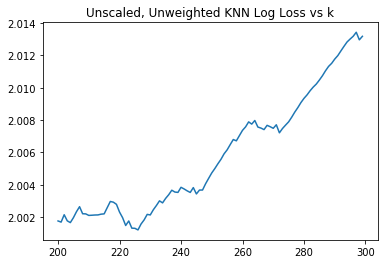

In [69]:
#k = 200
# 245 = 2.004
plt.plot(k_range, scores_unscaled_nonweight_lst)
plt.title('Unscaled, Unweighted KNN Log Loss vs k')

In [72]:
k_range = range(300, 350)
scores_scaled_nonweight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    score = cross_val_score(knn, X_train_scaled, y_train, cv = 3, scoring = 'neg_log_loss', n_jobs = -1)
    scores_scaled_nonweight_lst.append(score.mean() * -1)

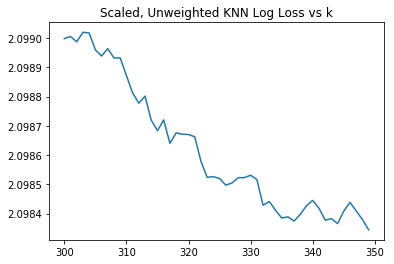

In [73]:
# k = 335
plt.plot(k_range, scores_scaled_nonweight_lst)
plt.title('Scaled, Unweighted KNN Log Loss vs k')

In [76]:
k_range = range(260, 325)
scores_unscaled_weight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, weights='distance')
    knn.fit(X_train, y_train)
    score = cross_val_score(knn, X_train, y_train, cv = 3, scoring = 'neg_log_loss', n_jobs = -1)
    scores_unscaled_weight_lst.append(score.mean() * -1)

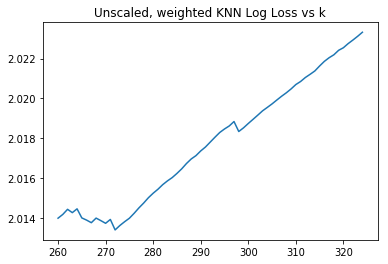

In [77]:
# k = 270
plt.plot(k_range, scores_unscaled_weight_lst)
plt.title('Unscaled, weighted KNN Log Loss vs k')

In [96]:
k_range = range(330, 365)
scores_scaled_weight_lst = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, weights='distance')
    knn.fit(X_train_scaled, y_train)
    score = cross_val_score(knn, X_train_scaled, y_train, cv = 3, scoring = 'neg_log_loss', n_jobs = -1)
    scores_scaled_weight_lst.append(score.mean() * -1)

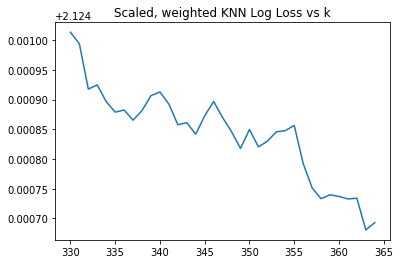

In [97]:
# k = 
plt.plot(k_range, scores_scaled_weight_lst)
plt.title('Scaled, weighted KNN Log Loss vs k')

The best KNN hyperparameters seems to be seems to be for unscaled, unweighted data, with around 285 neighbors.  

In [158]:
knn_final = KNeighborsClassifier(n_neighbors = 285, n_jobs = -1)
knn_final.fit(final_X_train, final_y_train)
    
knn_final_train_preds = knn_final.predict(final_X_train)
knn_final_test_preds = knn_final.predict(final_X_test)

knn_final_train_probs = knn_final.predict_proba(final_X_train)
knn_final_test_probs = knn_final.predict_proba(final_X_test)

print('{} has training accuracy of: {}'.format('Final KNN', accuracy_score(final_y_train, knn_final_train_preds)))
print('{} has test accuracy of: {}\n'.format('Final KNN', accuracy_score(final_y_test, knn_final_test_preds)))

print('{} has training log loss of: {}'.format('Final KNN', log_loss(final_y_train, knn_final_train_probs)))
print('{} has test log loss of: {}\n'.format('Final KNN', log_loss(final_y_test, knn_final_test_probs)))


Final KNN has training accuracy of: 0.335704324180172
Final KNN has test accuracy of: 0.32328837760357515

Final KNN has training log loss of: 1.8082169151557896
Final KNN has test log loss of: 1.8564379701381903



##### 9.3.3 - Random Forest Optimization

In [159]:
rf_final = rf_final = RandomForestClassifier(n_estimators = 700, max_depth = 25, min_samples_split= 2, 
                                  min_samples_leaf = 5, max_features = 'sqrt', 
                                  bootstrap = False, n_jobs=-1,
                                 verbose = 1, random_state = 42)
rf_final.fit(final_X_train, final_y_train)
    
rf_final_train_preds = rf_final.predict(final_X_train)
rf_final_test_preds = rf_final.predict(final_X_test)

rf_final_train_probs = rf_final.predict_proba(final_X_train)
rf_final_test_probs = rf_final.predict_proba(final_X_test)

print('{} has training accuracy of: {}'.format('Final random forest', accuracy_score(final_y_train, rf_final_train_preds)))
print('{} has test accuracy of: {}\n'.format('Final random forest', accuracy_score(final_y_test, rf_final_test_preds)))

print('{} has training log loss of: {}'.format('Final random forest', log_loss(final_y_train, rf_final_train_probs)))
print('{} has test log loss of: {}\n'.format('Final random forest', log_loss(final_y_test, rf_final_test_probs)))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 13.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed: 14.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed: 20.8min finis

Final random forest has training accuracy of: 0.8099695283229211
Final random forest has test accuracy of: 0.37311004843432516

Final random forest has training log loss of: 1.0185881442137408
Final random forest has test log loss of: 1.7057263644629346



##### 9.3.4 - Gradient Boosting Optimization


In [160]:
gb_final = GradientBoostingClassifier(n_estimators = 1000, learning_rate=0.1, max_depth=2,
                                     max_features = 7, min_samples_leaf = 3, min_samples_split = 19, 
                                     loss = 'deviance', subsample = 0.5, random_state = 42)
gb_final.fit(final_X_train, final_y_train)
    
gb_final_train_preds = gb_final.predict(final_X_train)
gb_final_test_preds = gb_final.predict(final_X_test)

gb_final_train_probs = gb_final.predict_proba(final_X_train)
gb_final_test_probs = gb_final.predict_proba(final_X_test)

print('{} has training accuracy of: {}'.format('Final gradient boost', accuracy_score(final_y_train, gb_final_train_preds)))
print('{} has test accuracy of: {}\n'.format('Final gradient boost', accuracy_score(final_y_test, gb_final_test_preds)))

print('{} has training log loss of: {}'.format('Final gradient boost', log_loss(final_y_train, gb_final_train_probs)))
print('{} has test log loss of: {}\n'.format('Final gradient boost', log_loss(final_y_test, gb_final_test_probs)))


Final gradient boost has training accuracy of: 0.40183267245788834
Final gradient boost has test accuracy of: 0.39130514852579174

Final gradient boost has training log loss of: 1.611572799726676
Final gradient boost has test log loss of: 1.6388223905466985



#### 9.4 - Accuracies by Crime Post Optimization
Again, I'd like to look at the accuracies after the optimization process.  Nothing drastic has changed, as logistic regression still has the best prediction for other and gradient boost still has the best prediction for robberies.  However, since KNN and random forest had the most improvement in accuracy and log loss score, the accuracies for these models showed the most improvements across most, if not all the crime categories. 

In [172]:
lr_train_accuracies = get_accuracies(lr_final_train_preds, final_y_train)
lr_test_accuracies = get_accuracies(lr_final_test_preds, final_y_test)

knn_train_accuracies = get_accuracies(knn_final_train_preds, final_y_train)
knn_test_accuracies = get_accuracies(knn_final_test_preds, final_y_test) 

rf_train_accuracies = get_accuracies(rf_final_train_preds, final_y_train)
rf_test_accuracies = get_accuracies(rf_final_test_preds, final_y_test)

gb_train_accuracies = get_accuracies(gb_final_train_preds, final_y_train)
gb_test_accuracies = get_accuracies(gb_final_test_preds, final_y_test)

In [173]:
tmp = {'lr': lr_test_accuracies, 'knn': knn_test_accuracies,
       'rf': rf_test_accuracies, 'gb': gb_test_accuracies}
final_test_accuracy_df = pd.DataFrame(tmp, 
                                          index = sorted(df['Crm Cd Desc'].unique()),
                                         columns = ['lr', 'knn', 'rf', 'gb'])

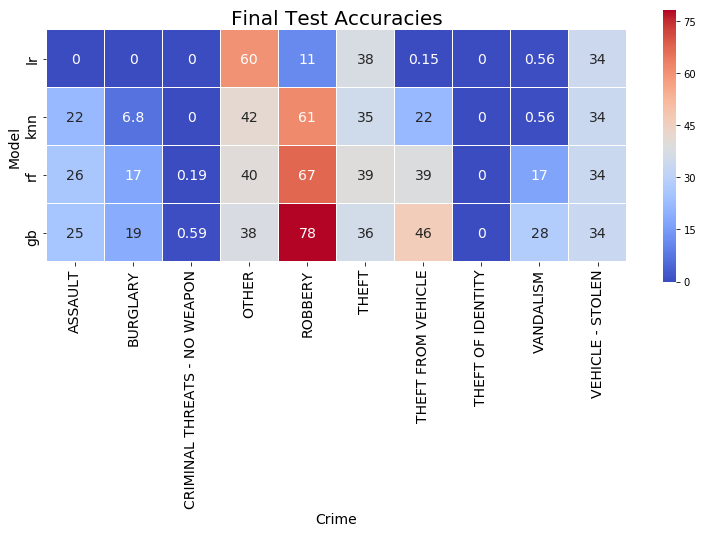

In [263]:
fig, ax = plt.subplots(figsize=(13, 5))

sns.heatmap(final_test_accuracy_df.T, cmap = 'coolwarm', square = True, linewidths=0.1, annot=True, annot_kws={'size':14})
plt.title('Final Test Accuracies', fontsize = 20)
plt.xlabel('Crime', fontsize = 14)
plt.ylabel('Model', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)


### 10 - Feature Importance
The last thing I wanted to visit is feature importance for each model.  Logistic regression and KNN do not have built in functions for finding feature importance, but a simple way to find feature importance for logistic regression is to multiply the standard deviation by the coefficients of each feature.  Unfortunately I could not find a way to find feature importance for KNN, at least not without long runtimes.  Random forest and gradient boosting have built in feature importance functions, which I have made use of here.  

#### 10.1 - Logistic Regression Feature Importance
For logistic regression, the model thinks that the district number is by far the most important feature available, with the premise description being a far, far second, and the rest of the features are negligible in terms of importance.

In [207]:
tmp1 = []
tmp2 = []
for i in range(27):
    tmp1.append(lr_final.coef_[:,i])
    tmp2.append(tmp1[i].mean())

In [208]:
lr_fi = pd.DataFrame({'Feature name':abs(np.std(final_X_train, 0) * tmp2).index, 'Importance': abs(np.std(final_X_train, 0) * tmp2).values})
lr_fi.sort_values(['Importance'], ascending = True, inplace = True)

# abs(np.std(X_train, 0) * tmp2)

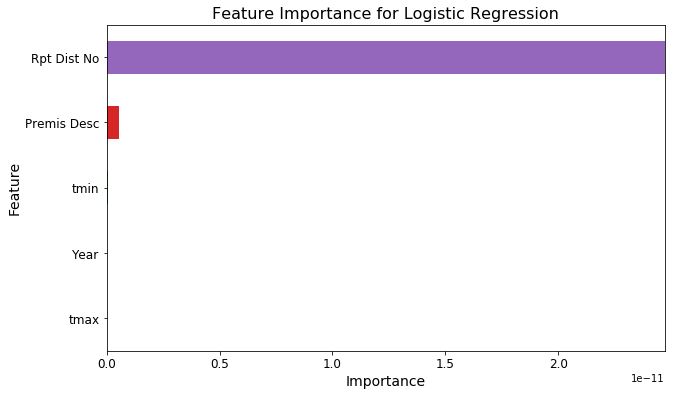

In [221]:
lr_fi[-5:].plot('Feature name', 'Importance', kind = 'barh',legend=False, figsize=(10,6))
plt.title('Feature Importance for Logistic Regression', fontsize = 16)
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)

#### 10.2 - Random Forest Feature Importance
The top five most important features for random forest are the premise description, location, district number, and time of day.  The premise description is by far the most important feature, although the the difference in feature importance is not nearly as big as that of logistic regression.

In [210]:
rf_fi = pd.DataFrame({'Feature name': X_train.columns, 'Importance': rf_final.feature_importances_})
rf_fi.sort_values(['Importance'], ascending=True, inplace=True)

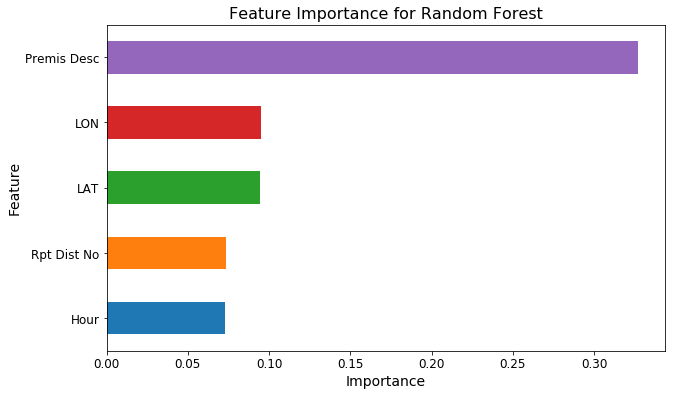

In [222]:
rf_fi[-5:].plot('Feature name', 'Importance', kind = 'barh',legend=False, figsize=(10,6))
plt.title('Feature Importance for Random Forest', fontsize = 16)
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)

#### 10.3 -  Gradient Boosting Feature Importance
Lastly, we have gradient boosting.  In this case, the premise description is by far the most important feature, with the time of day, location, and district number following up.  It is interesting that the two tree based models places high importance on the same 5 features, but different orders.

In [217]:
gb_fi = pd.DataFrame({'Feature name': X_train.columns, 'Importance': gb_final.feature_importances_})
gb_fi.sort_values(['Importance'], ascending=True, inplace=True)

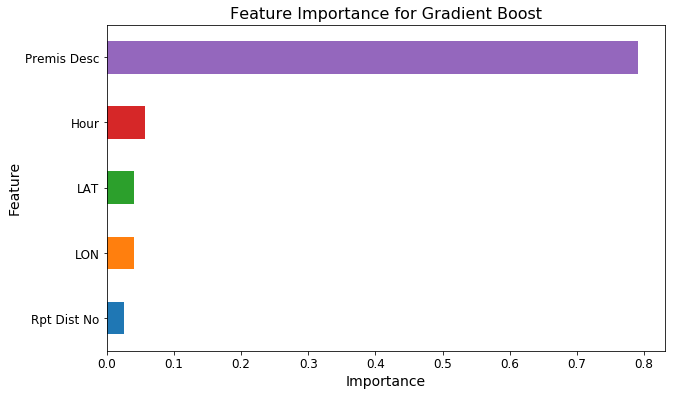

In [232]:
gb_fi[-5:].plot('Feature name', 'Importance', kind = 'barh',legend=False, figsize=(10,6))
plt.title('Feature Importance for Gradient Boost', fontsize = 16)
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)